In [1]:
!pip uninstall -y keras 
!pip install keras==2.2.4

Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Successfully uninstalled keras-2.7.0
     |████████████████████████████████| 312 kB 4.2 MB/s 
     |████████████████████████████████| 50 kB 9.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.2.4 which is incompatible.


In [2]:
!pip uninstall -y tensorflow 
!pip install tensorflow==1.14.0 

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 109.3 MB 76 kB/s 
     |████████████████████████████████| 488 kB 76.5 MB/s 
     |████████████████████████████████| 3.1 MB 56.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


In [3]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


# 얼굴 인식

copy from : https://github.com/santhalakshminarayana/face-recognition/blob/master/Face_Recognition.ipynb

아티클 : https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5


얼굴 부분 추출과, 추출된 얼굴의 분류 2단계로 진행됨.

얼굴 추출은 이미 학습된 모델을 가져와서 추출하고, 추출된 부분을 별개의 파일로 저장.

별개의 파일로 저장된 얼굴 영상을 VGGFace 모델을 가져와서 feature를 추출함.

이렇게 추출한 feature를 입력으로 얼굴 분류 모델을 학습한다.




# 데이터 준비

## 데이터 준비

아래와 같이 데이터를 준비한다.
반드시 확장자가 'jpg'이어야 한다.

<br> face_data.zip으로 묶어서 구글드라이브의 tmp 폴더에 가져다 놓는다.

```
face_data/
  Images/
    jobs_1.jpg
    jobs_2.jpg
    ...
    faker_1.jpg
    faker_2.jpg
    ...
    iu_1.jpg
    iu_2.jpg
  Test_images/
    jobs_11.jpg
    jobs_12.jpg
    ...
    faker_11.jpg
    faker_12.jpg
    ...
    iu_11.jpg
    iu_12.jpg
```



구글 드라이브 마운트

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


혹시 기존에 파일들이 있으면 깔금히 지우고 시작

In [5]:
!rm -rf __MACOSX
!rm -rf face_data.zip
!rm -rf face_data

구글 드라이브에서 colab 으로 파일 카피

In [6]:
!cp '/content/drive/MyDrive/temp/face_data.zip' ./

압축 풀기

In [7]:
!unzip face_data.zip -d /content/face_data

Archive:  face_data.zip
  inflating: /content/face_data/Images/dog_1.jpg  
  inflating: /content/face_data/Images/dog_10.jpg  
  inflating: /content/face_data/Images/dog_2.jpg  
  inflating: /content/face_data/Images/dog_3.jpg  
  inflating: /content/face_data/Images/dog_4.jpg  
  inflating: /content/face_data/Images/dog_5.jpg  
  inflating: /content/face_data/Images/dog_6.jpg  
  inflating: /content/face_data/Images/dog_7.jpg  
  inflating: /content/face_data/Images/dog_8.jpg  
  inflating: /content/face_data/Images/dog_9.jpg  
  inflating: /content/face_data/Images/ein_1.jpg  
  inflating: /content/face_data/Images/ein_10.jpg  
 extracting: /content/face_data/Images/ein_2.jpg  
  inflating: /content/face_data/Images/ein_3.jpg  
 extracting: /content/face_data/Images/ein_4.jpg  
  inflating: /content/face_data/Images/ein_5.jpg  
 extracting: /content/face_data/Images/ein_6.jpg  
  inflating: /content/face_data/Images/ein_7.jpg  
  inflating: /content/face_data/Images/ein_8.jpg  
  inf

이미를 읽을 위치를 설정


폴더 Images, Test_images가 있는 위치를 WORKING_PATH로 설정

In [8]:
WORKING_PATH='/content/face_data'

In [9]:
!ls -al $WORKING_PATH

total 16
drwxr-xr-x 4 root root 4096 Jan  6 08:31 .
drwxr-xr-x 1 root root 4096 Jan  6 08:31 ..
drwxr-xr-x 2 root root 4096 Jan  6 08:31 Images
drwxr-xr-x 2 root root 4096 Jan  6 08:31 Test_images


폴더 Images, Test_images가 있는 위치로 이동

In [10]:
%cd $WORKING_PATH

/content/face_data


Images 폴더 안의 영상 파일이름을 구한다.

In [11]:
import os
import glob

TARGET_FOLDER_NAME = "Images"

image_path_names=[]
person_names=set()
for file_name in glob.glob(WORKING_PATH+'/'+TARGET_FOLDER_NAME+'/*_[1-9]*.jpg'):
  image_path_names.append(file_name)
  person_names.add(image_path_names[-1].split('/')[-1].split('_')[0])

이미지 파일 갯수

In [12]:
len(image_path_names)

80

파일 이름들 보기

In [13]:
print(image_path_names)

['/content/face_data/Images/musk_1.jpg', '/content/face_data/Images/dog_7.jpg', '/content/face_data/Images/musk_2.jpg', '/content/face_data/Images/hong_10.jpg', '/content/face_data/Images/ein_6.jpg', '/content/face_data/Images/hong_9.jpg', '/content/face_data/Images/musk_10.jpg', '/content/face_data/Images/son_5.jpg', '/content/face_data/Images/dog_5.jpg', '/content/face_data/Images/hong_2.jpg', '/content/face_data/Images/hong_8.jpg', '/content/face_data/Images/jung_1.jpg', '/content/face_data/Images/musk_7.jpg', '/content/face_data/Images/shin_10.jpg', '/content/face_data/Images/iu_9.jpg', '/content/face_data/Images/son_7.jpg', '/content/face_data/Images/ein_4.jpg', '/content/face_data/Images/shin_3.jpg', '/content/face_data/Images/iu_1.jpg', '/content/face_data/Images/ein_9.jpg', '/content/face_data/Images/musk_3.jpg', '/content/face_data/Images/iu_7.jpg', '/content/face_data/Images/shin_1.jpg', '/content/face_data/Images/dog_6.jpg', '/content/face_data/Images/shin_5.jpg', '/content/

사람 이름 보기

In [14]:
print(person_names)

{'musk', 'jung', 'iu', 'shin', 'hong', 'dog', 'ein', 'son'}


# 얼굴 분류를 위한 얼굴부분 데이터 만들기

얼굴 부분 탐지하여 crop한다.


dlib의 face detector를 사용

face detector 모델을 다운로드

In [15]:
# Download Dlib CNN face detector
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2

--2022-01-06 08:31:40--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   720KB/s    in 0.9s    

2022-01-06 08:31:41 (720 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



압축 풀기

In [16]:
!bzip2 -dk mmod_human_face_detector.dat.bz2

## FaceDetector 로딩

In [17]:
import cv2
import matplotlib.pyplot as plt
import dlib

## Images 폴더 파일들 crop

Images 폴더의 파일들을 읽어 Images_crop에 생성

모델 로딩

In [18]:
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

저장될 폴더 이름

In [19]:
CROP_OUTPUT_FOLDER_NAME = 'Images_crop'

crop되어 저장될 폴더 생성

In [20]:
 os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME)

각 카테고리 별 폴더 생성

In [21]:
# For each person create a separate folder
for person in person_names:
  os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+person+'/')

In [22]:
!ls -al $CROP_OUTPUT_FOLDER_NAME

total 40
drwxr-xr-x 10 root root 4096 Jan  6 08:31 .
drwxr-xr-x  5 root root 4096 Jan  6 08:31 ..
drwxr-xr-x  2 root root 4096 Jan  6 08:31 dog
drwxr-xr-x  2 root root 4096 Jan  6 08:31 ein
drwxr-xr-x  2 root root 4096 Jan  6 08:31 hong
drwxr-xr-x  2 root root 4096 Jan  6 08:31 iu
drwxr-xr-x  2 root root 4096 Jan  6 08:31 jung
drwxr-xr-x  2 root root 4096 Jan  6 08:31 musk
drwxr-xr-x  2 root root 4096 Jan  6 08:31 shin
drwxr-xr-x  2 root root 4096 Jan  6 08:31 son


In [23]:
# print(top)
# print(left)
# print(right)
# print(bottom)

In [24]:
import numpy as np
TARGET_IMAGE_PATH_NAMES = image_path_names

for file_name in TARGET_IMAGE_PATH_NAMES:

  # 이미지 읽기
  img=cv2.imread(file_name)

  # 모델의 입력에 맞게 변환
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 박스 검출
  rects=dnnFaceDetector(gray,1)

  # 검출된 박스에서 left, top, right, bottom 값 구하기
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue
  # 버그 수정
  top = np.clip(top, 0 ,9999999)
  left = np.clip(left, 0 ,9999999)
  # width와 height 구하기
  width=right-left
  height=bottom-top

  # 이미지 crop
  img_crop=img[top:top+height,left:left+width]

  # 저장할 파일 이름 만들기
  img_path=WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  # crop한 이미지를 파일로 쓰기
  cv2.imwrite(img_path,img_crop)

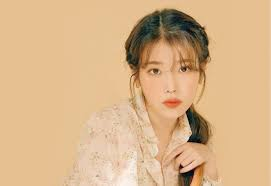

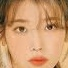

In [25]:
from IPython.display import Image
display(Image('Images/iu_10.jpg'))
display(Image('Images_crop/iu/iu_10.jpg'))

## Test_Image 파일들 crop

Test_Images의 파일들을 읽어 Test_Images_crop에 생성

Images 폴더 안의 영상 파일이름을 구한다.

In [26]:
import os
import glob

TARGET_FOLDER_NAME = "Test_images"

test_image_path_names=[]
for file_name in glob.glob(WORKING_PATH+'/'+TARGET_FOLDER_NAME+'/*_[1-9]*.jpg'):
  test_image_path_names.append(file_name)

이미지 파일 갯수

In [27]:
len(test_image_path_names)

80

파일 이름들 보기

In [28]:
print(test_image_path_names)

['/content/face_data/Test_images/son_14.jpg', '/content/face_data/Test_images/shin_17.jpg', '/content/face_data/Test_images/hong_11.jpg', '/content/face_data/Test_images/ein_11.jpg', '/content/face_data/Test_images/jung_18.jpg', '/content/face_data/Test_images/shin_16.jpg', '/content/face_data/Test_images/musk_19.jpg', '/content/face_data/Test_images/ein_15.jpg', '/content/face_data/Test_images/jung_20.jpg', '/content/face_data/Test_images/jung_19.jpg', '/content/face_data/Test_images/iu_12.jpg', '/content/face_data/Test_images/hong_19.jpg', '/content/face_data/Test_images/musk_12.jpg', '/content/face_data/Test_images/son_20.jpg', '/content/face_data/Test_images/musk_16.jpg', '/content/face_data/Test_images/shin_13.jpg', '/content/face_data/Test_images/iu_20.jpg', '/content/face_data/Test_images/ein_16.jpg', '/content/face_data/Test_images/son_16.jpg', '/content/face_data/Test_images/dog_20.jpg', '/content/face_data/Test_images/shin_19.jpg', '/content/face_data/Test_images/iu_16.jpg', 

In [29]:
CROP_OUTPUT_FOLDER_NAME = 'Test_Images_crop'

crop되어 저장될 폴더 생성

In [30]:
os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME)

각 카테고리 별 폴더 생성

In [31]:
# For each person create a separate folder
for person in person_names:
  os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+person+'/')

In [32]:
!ls -al $CROP_OUTPUT_FOLDER_NAME

total 40
drwxr-xr-x 10 root root 4096 Jan  6 08:31 .
drwxr-xr-x  6 root root 4096 Jan  6 08:31 ..
drwxr-xr-x  2 root root 4096 Jan  6 08:31 dog
drwxr-xr-x  2 root root 4096 Jan  6 08:31 ein
drwxr-xr-x  2 root root 4096 Jan  6 08:31 hong
drwxr-xr-x  2 root root 4096 Jan  6 08:31 iu
drwxr-xr-x  2 root root 4096 Jan  6 08:31 jung
drwxr-xr-x  2 root root 4096 Jan  6 08:31 musk
drwxr-xr-x  2 root root 4096 Jan  6 08:31 shin
drwxr-xr-x  2 root root 4096 Jan  6 08:31 son


In [33]:
TARGET_IMAGE_PATH_NAMES = test_image_path_names

for file_name in TARGET_IMAGE_PATH_NAMES:

  # 이미지 읽기
  img=cv2.imread(file_name)

  # 모델의 입력에 맞게 변환
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 박스 검출
  rects=dnnFaceDetector(gray,1)

  # 검출된 박스에서 left, top, right, bottom 값 구하기
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue
  top = np.clip(top, 0 ,9999999)
  left = np.clip(left, 0 ,9999999)
  # width와 height 구하기
  width=right-left
  height=bottom-top

  # 이미지 crop
  img_crop=img[top:top+height,left:left+width]

  # 저장할 파일 이름 만들기
  img_path=WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  # crop한 이미지를 파일로 쓰기
  cv2.imwrite(img_path,img_crop)

이제 다음과 같은 구조의 폴더가 생성되었다.
Images_crop, Test_Images_crop 밑에는 얼굴부분만 crop된 이미지들이 생성되어 있다.

```
Directory structure :
|--Images /
|  |-- (60 images)
|
|--Images_crop /
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|
|--Test_Images / 
|  |-- .. / (18 images)
|
|--Test_Images_crop / 
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|--mmod_human_face_detector.dat
```

# VGGFace 모델 로딩

얼굴 피쳐 추출을 위해 VGGFace를 사용한다.

https://github.com/rcmalli/keras-vggface

In [34]:
!pip install keras_vggface

In [35]:
!pip install keras_applications

In [36]:
from keras_vggface.vggface import VGGFace

vgg_face_model = VGGFace(include_top=False, input_shape=(224, 224, 3))

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

58916864/58909280 [==============================] - 14s 0us/step




In [37]:
vgg_face_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

# 학습 데이터 로딩

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D, Input, Flatten
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [40]:
#Prepare Training Data
x_train=[]
y_train=[]

person_folders=os.listdir(WORKING_PATH+'/Images_crop/')
person_rep=dict()


for i,person in enumerate(person_folders):

  person_rep[i]=person

  image_names=os.listdir('Images_crop/'+person+'/')
  for image_name in image_names:
    # 이미지 로딩
    img=load_img(WORKING_PATH+'/Images_crop/'+person+'/'+image_name,target_size=(224,224))

    # numpy로 변환
    img=img_to_array(img)

    # img.shape = (224, 224, 3) -> (1, 224, 224, 3)
    img=np.expand_dims(img,axis=0)   # VGGFace는 복수의 영상을 한번에 처리한다.이에 맞도록 입력 모양 변형

    # 데이터 전처리
    img=preprocess_input(img)

    # 얼굴의 feature를 추출한다.
    img_encoded = vgg_face_model.predict(img)  # 얼굴의 feature를 추출한다.

    x_train.append(np.squeeze(K.eval(img_encoded)).tolist())
    y_train.append(i)

In [41]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [42]:
#Prepare Test Data
x_test=[]
y_test=[]
person_folders=os.listdir(WORKING_PATH+'/Test_Images_crop/')
for i,person in enumerate(person_folders):
  image_names=os.listdir('Test_Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(WORKING_PATH+'/Test_Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encoded = vgg_face_model.predict(img)  # 얼굴의 feature를 추출한다.
    x_test.append(np.squeeze(K.eval(img_encoded)).tolist())
    y_test.append(i)

In [43]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [44]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(70, 7, 7, 512)
(70,)
(70, 7, 7, 512)
(70,)


In [45]:
print(x_train.shape)

(70, 7, 7, 512)


# Face 분류 모델 정의

In [46]:
print(x_train.shape[1:])

(7, 7, 512)


In [47]:
classifier_model = Sequential()
classifier_model.add(Input(x_train.shape[1:])) # shape = (7, 7, 512)
classifier_model.add(Flatten())
classifier_model.add(Dense(units=100, kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10, kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=len(person_folders), kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# 분류 모델 학습

In [48]:
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam',metrics=['accuracy'])

classifier_model.fit(x_train, y_train, epochs=100, validation_data=(x_test,y_test))

Train on 70 samples, validate on 70 samples
Epoch 1/100
70/70 [==============================] - 0s 5ms/sample - loss: 2.1832 - acc: 0.2143 - val_loss: 1.5002 - val_acc: 0.5143
Epoch 2/100
70/70 [==============================] - 0s 1ms/sample - loss: 1.0383 - acc: 0.7143 - val_loss: 1.1158 - val_acc: 0.6714
Epoch 3/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.7378 - acc: 0.8429 - val_loss: 0.9895 - val_acc: 0.7286
Epoch 4/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.6211 - acc: 0.9714 - val_loss: 0.8975 - val_acc: 0.7571
Epoch 5/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.5719 - acc: 0.9714 - val_loss: 0.8460 - val_acc: 0.7429
Epoch 6/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.5105 - acc: 0.9714 - val_loss: 0.7852 - val_acc: 0.7857
Epoch 7/100
70/70 [==============================] - 0s 1ms/sample - loss: 0.5554 - acc: 0.9714 - val_loss: 0.8212 - val_acc: 0.7571
Epoch 8/100
70/70 [======

# 얼굴 인식 실행

In [49]:
def plot(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [50]:
os.mkdir(WORKING_PATH+'/Predictions')

In [56]:
print(top)
print(left)
print(right)
print(bottom)

-8
518
1025
499


/content/face_data/Test_images/son_14.jpg


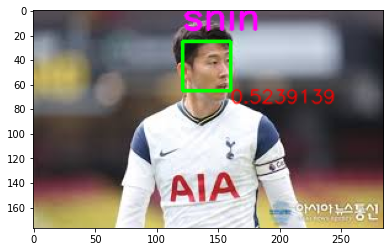

/content/face_data/Test_images/shin_17.jpg


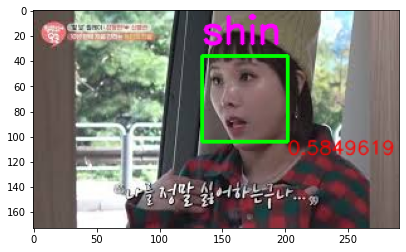

/content/face_data/Test_images/hong_11.jpg


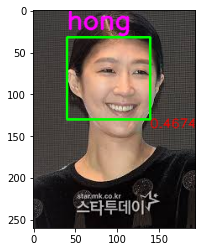

/content/face_data/Test_images/ein_11.jpg


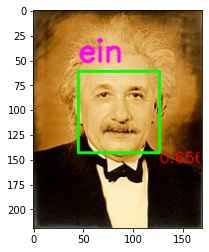

/content/face_data/Test_images/jung_18.jpg


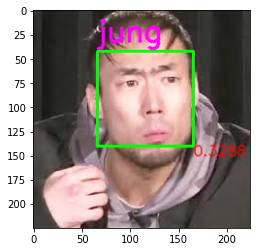

/content/face_data/Test_images/shin_16.jpg


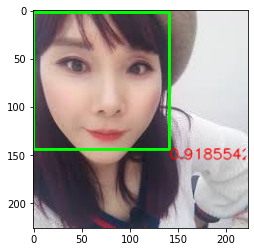

/content/face_data/Test_images/musk_19.jpg


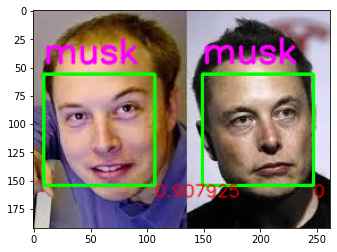

/content/face_data/Test_images/ein_15.jpg


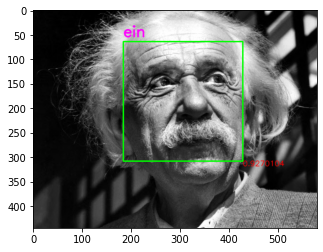

/content/face_data/Test_images/jung_20.jpg


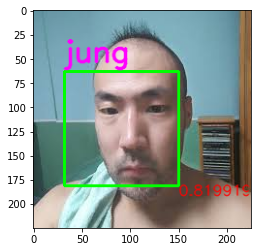

/content/face_data/Test_images/jung_19.jpg


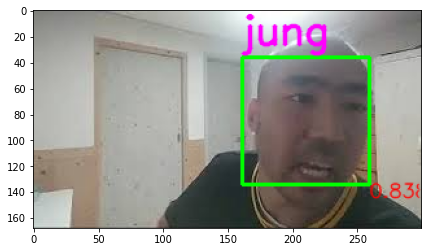

/content/face_data/Test_images/iu_12.jpg


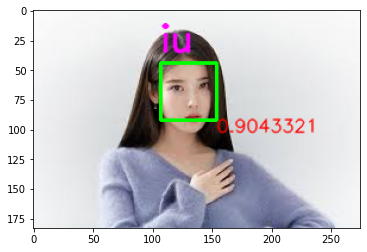

/content/face_data/Test_images/hong_19.jpg


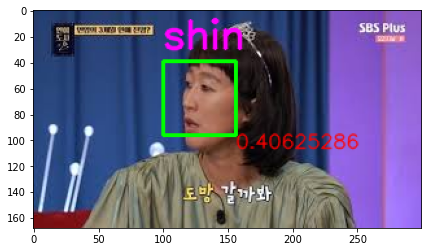

/content/face_data/Test_images/musk_12.jpg


error: ignored

In [57]:
import numpy as np
for img_name in os.listdir(WORKING_PATH+'/Test_images/'):
  if img_name=='crop_img.jpg':
    continue
  # Load Image
  img=cv2.imread(WORKING_PATH+'/Test_images/'+img_name)
  print(WORKING_PATH+'/Test_images/'+img_name) # DEV
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 얼굴 탐지
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    # Extract Each Face
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
    width=right-left
    height=bottom-top
    img_crop=img[top:top+height,left:left+width]
    cv2.imwrite(WORKING_PATH+'/Test_images/crop_img.jpg',img_crop)
    
    top = np.clip(top, 0, 9999999)
    # 얼굴 영역 crop
    crop_img=load_img(WORKING_PATH+'/Test_images/crop_img.jpg',target_size=(224,224))
    crop_img=img_to_array(crop_img)
    crop_img=np.expand_dims(crop_img,axis=0)
    crop_img=preprocess_input(crop_img)
    img_encode=vgg_face_model.predict(crop_img)

    # 얼굴 영역 인식
    embed=K.eval(img_encode)
    person=classifier_model.predict(embed)
    name=person_rep[np.argmax(person)]
    os.remove(WORKING_PATH+'/Test_images/crop_img.jpg')
    cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
    img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
  # Save images with bounding box,name and accuracy 
  cv2.imwrite(WORKING_PATH+'/Predictions/'+img_name,img)
  plot(img)